## 1. Cleaning Data

In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import contextily as ctx
from shapely.geometry import Point


In [14]:
aggregated_votes_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Aggregated_Votes_By_Borough_And_Party.xlsx'
aggregated_votes_data = pd.read_excel(aggregated_votes_path)

geojson_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/london_boroughs.json'
london_boroughs_geo = gpd.read_file(geojson_path)

london_boroughs_geo = london_boroughs_geo.rename(columns={'name': 'Borough'})

merged_data = london_boroughs_geo.set_index('Borough').join(aggregated_votes_data.set_index('Borough'))
merged_data.reset_index(inplace=True)

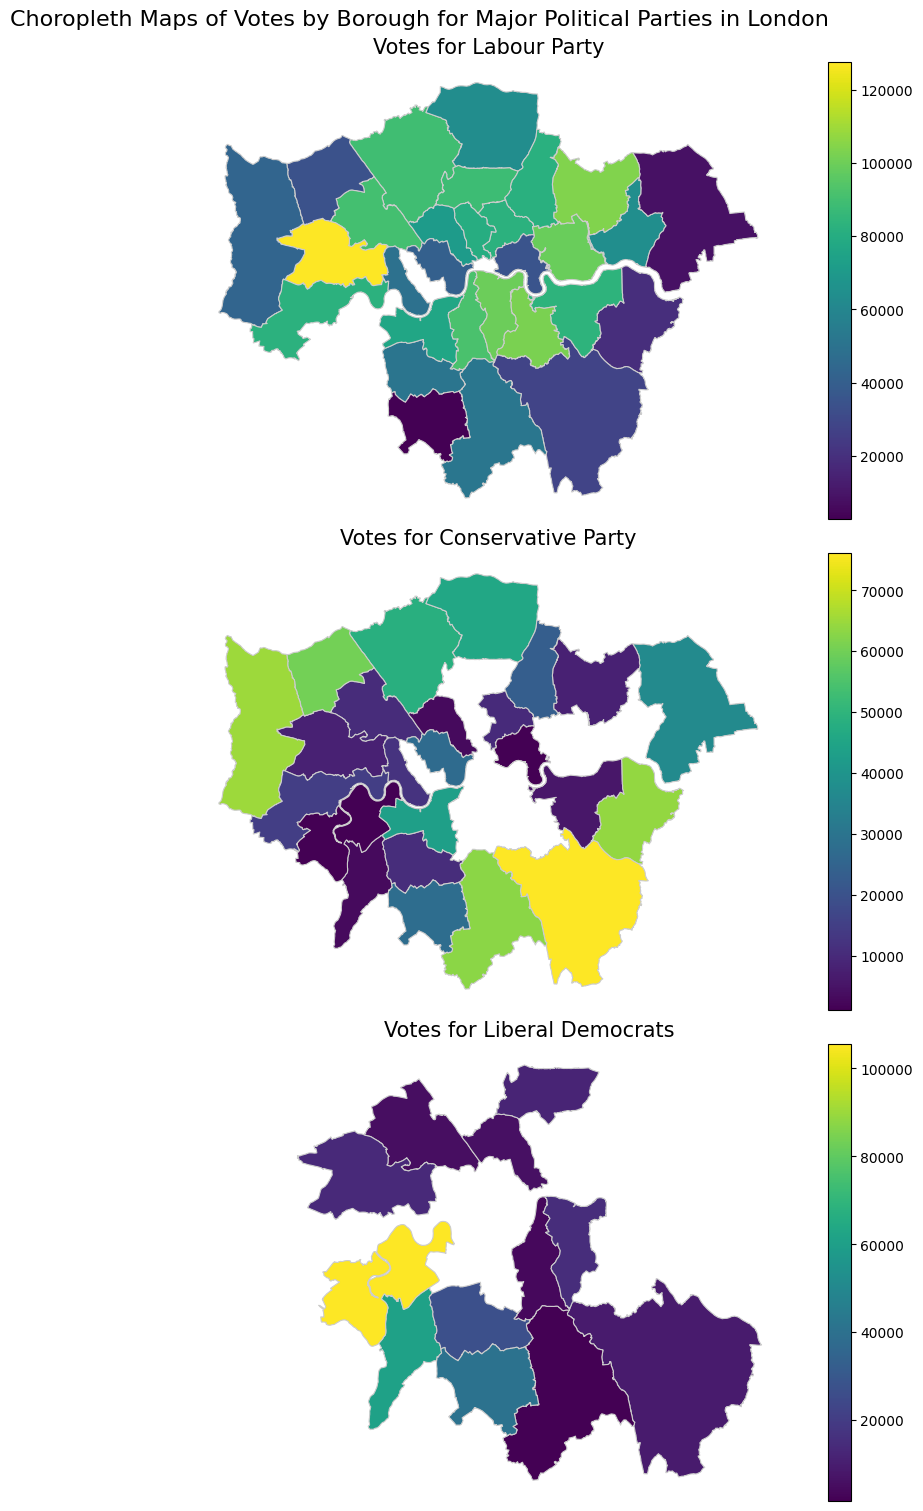

In [15]:
major_parties = aggregated_votes_data['Party name'].value_counts().index[:3]  # Taking top 3 parties

fig, axes = plt.subplots(nrows=len(major_parties), figsize=(10, 15), constrained_layout=True)

for i, party in enumerate(major_parties):
    party_data = merged_data[merged_data['Party name'] == party]

    party_data.plot(column='Votes', cmap='viridis', linewidth=0.8, ax=axes[i], edgecolor='0.8', legend=True)

    axes[i].set_title(f'Votes for {party}', fontdict={'fontsize': '15', 'fontweight' : '3'})
    axes[i].axis('off')

plt.suptitle('Choropleth Maps of Votes by Borough for Major Political Parties in London', fontsize=16)
plt.show()


### 1.2 Airbnb Density

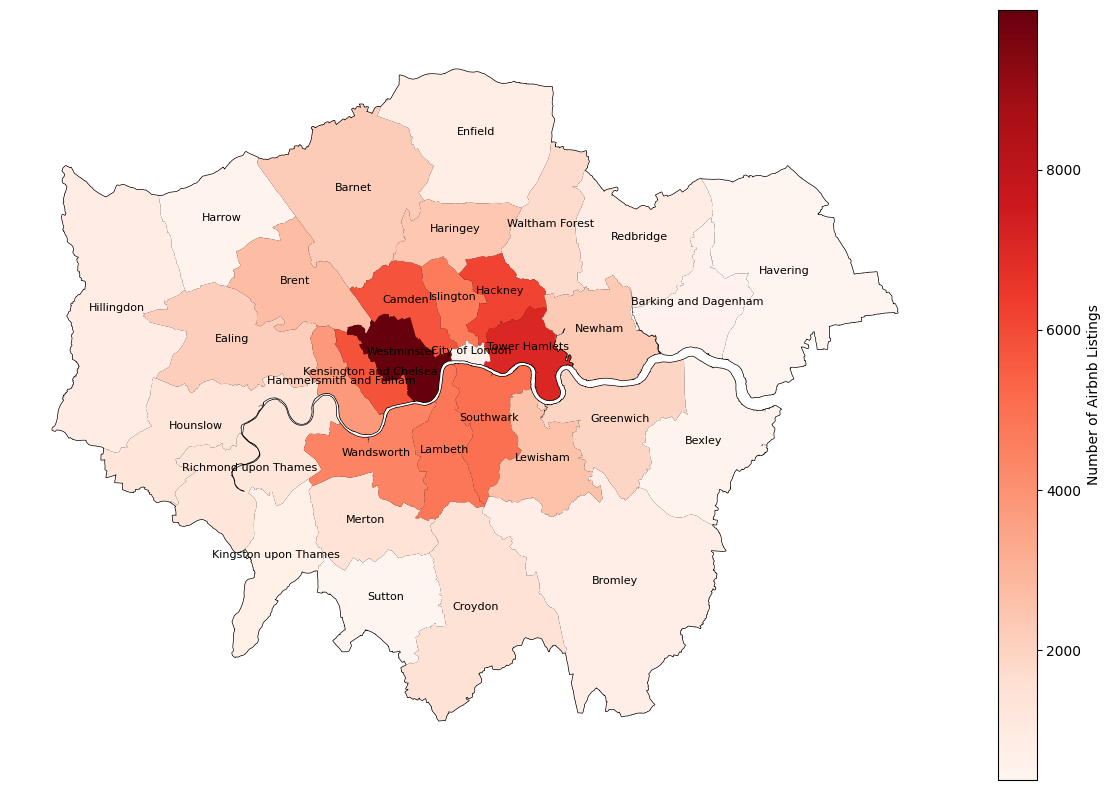

In [16]:
airbnb_listings_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Airbnb_listings_with_boroughs.csv'
borough_boundaries_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/london_boroughs.json'

airbnb_listings_data = pd.read_csv(airbnb_listings_path)

gdf_airbnb_listings = gpd.GeoDataFrame(
    airbnb_listings_data, 
    geometry=gpd.points_from_xy(airbnb_listings_data.longitude, airbnb_listings_data.latitude)
)

london_boroughs = gpd.read_file(borough_boundaries_path)

airbnb_counts_per_borough = gdf_airbnb_listings['Borough'].value_counts().reset_index()
airbnb_counts_per_borough.columns = ['Borough', 'Count']

london_boroughs = london_boroughs.merge(airbnb_counts_per_borough, how='left', left_on='name', right_on='Borough')
london_boroughs['Count'] = london_boroughs['Count'].fillna(0)  # Fill NaNs with 0

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
london_boroughs.plot(ax=ax, color='white', edgecolor='black')
london_boroughs.plot(ax=ax, column='Count', cmap='Reds', legend=True, 
                     legend_kwds={'label': "Number of Airbnb Listings"})
plt.axis('off')  # Removes the axis

for idx, row in london_boroughs.iterrows():
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['name'], 
             horizontalalignment='center', fontdict={'color':'black', 'size': 8})

plt.show()


### 1.3 Graphs

#### 1.3.1 Crime

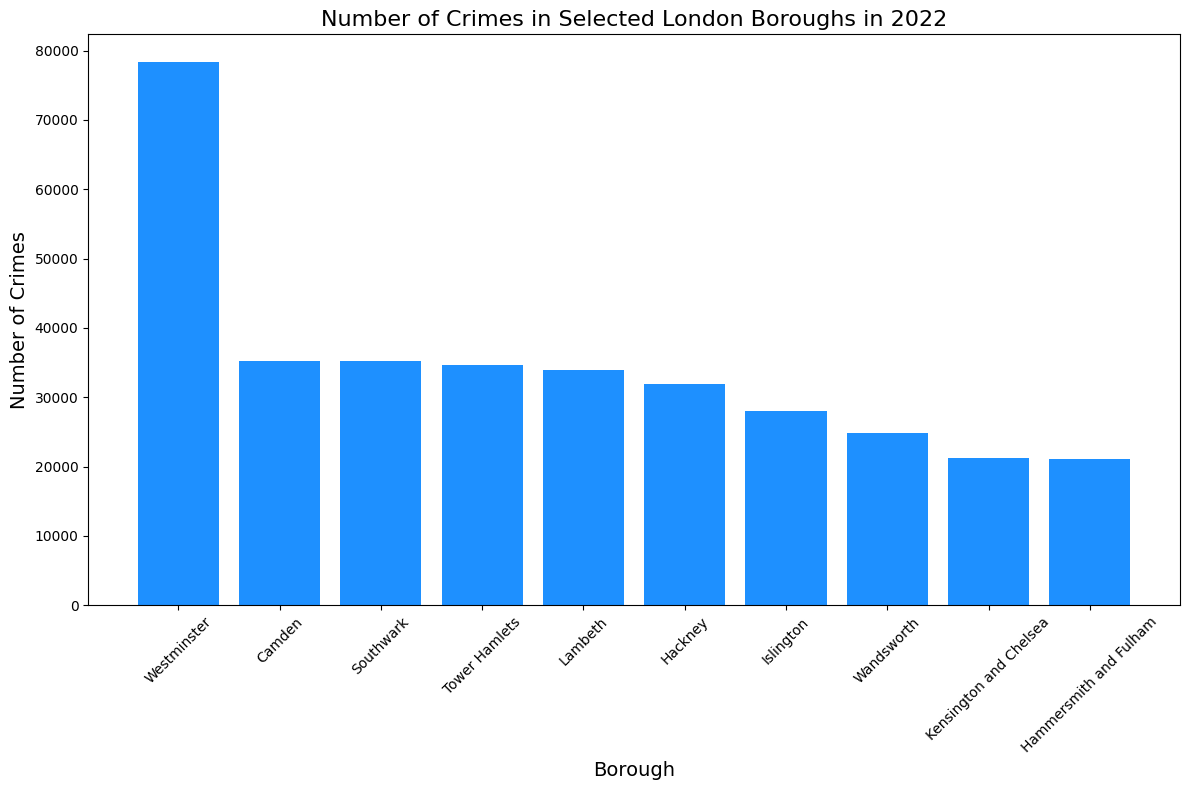

In [17]:
# File path
crime_data_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/Aggregated_Crimes_Per_Borough_Per_Year.csv'

# Load the crime data
crime_data = pd.read_csv(crime_data_path)

# Filter the data for the specified boroughs and the year 2022
selected_boroughs = [
    'Camden', 'Islington', 'Westminster', 'Kensington and Chelsea',
    'Hammersmith and Fulham', 'Tower Hamlets', 'Wandsworth', 'Southwark',
    'Hackney', 'Lambeth'
]
crime_data_selected_boroughs = crime_data[(crime_data['Borough'].isin(selected_boroughs)) & (crime_data['Year'] == 2022)]

# Sort the data for the selected boroughs
crime_data_selected_boroughs_sorted = crime_data_selected_boroughs.sort_values('Crimes', ascending=False)

# Plotting the bar graph for the selected boroughs
plt.figure(figsize=(12, 8))
plt.bar(crime_data_selected_boroughs_sorted['Borough'], crime_data_selected_boroughs_sorted['Crimes'], color='dodgerblue')
plt.title('Number of Crimes in Selected London Boroughs in 2022', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


#### 1.3.2 Income

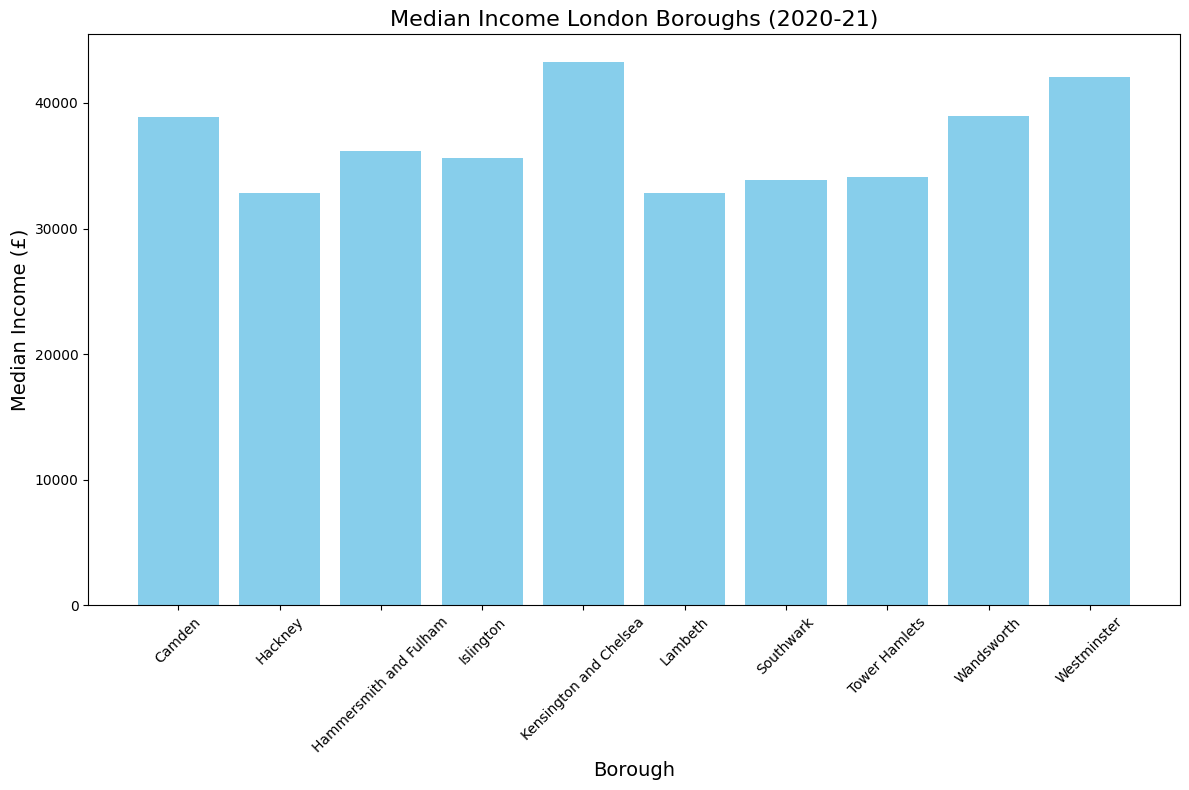

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

income_data_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/income-of-tax-payers.xlsx'

income_data = pd.read_excel(income_data_path, sheet_name='Total Income')

income_sheet = income_data.drop([0, 1]).rename(columns={
    'Unnamed: 0': 'Area',
    '2020-21': 'Number of Individuals',
    'Unnamed: 2': 'Mean £',
    'Unnamed: 3': 'Median £'
})
income_sheet['Median £'] = pd.to_numeric(income_sheet['Median £'], errors='coerce')

selected_boroughs = [
    'Camden', 'Islington', 'Westminster', 'Kensington and Chelsea',
    'Hammersmith and Fulham', 'Tower Hamlets', 'Wandsworth', 'Southwark',
    'Hackney', 'Lambeth'
]
selected_boroughs_income = income_sheet[income_sheet['Area'].isin(selected_boroughs)]

plt.figure(figsize=(12, 8))
plt.bar(selected_boroughs_income['Area'], selected_boroughs_income['Median £'], color='skyblue')
plt.title('Median Income London Boroughs (2020-21)', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Median Income (£)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/t6/2l4skldj33v76fg1nxfgvs7c0000gn/T/ipykernel_48781/989980498.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_median_incomes['London Median Income'] = london_median_income


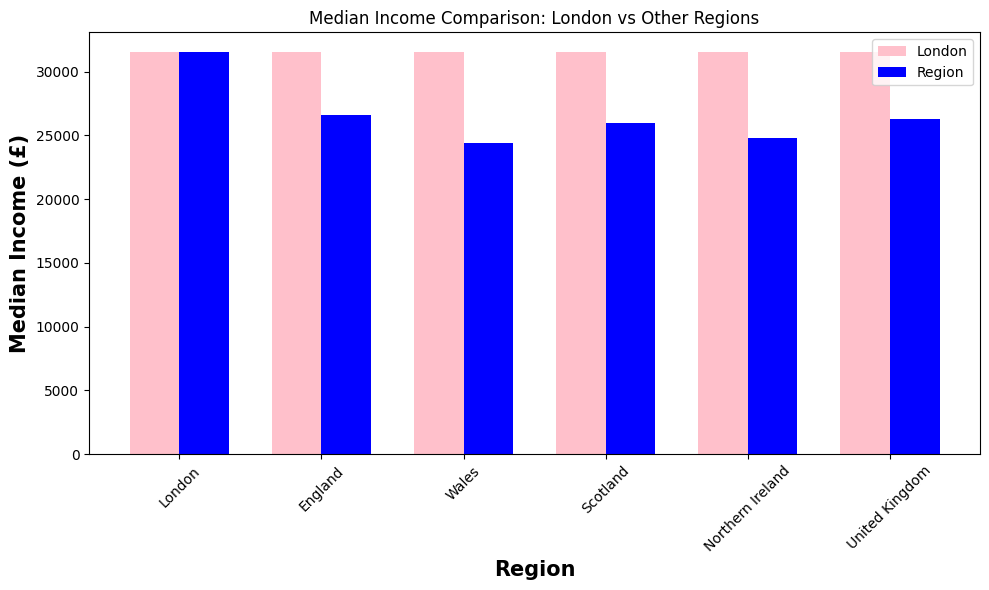

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/bashir/Documents/UCL/Foundations of Spatial Data Science/income-of-tax-payers.xlsx'
income_data = pd.read_excel(file_path, skiprows=1)

income_data.columns = ['Area', 'Number of Individuals', 'Mean Income', 'Median Income']

region_median_incomes = income_data[income_data['Area'].isin(['London', 'England', 'Wales', 'Northern Ireland', 'Scotland', 'United Kingdom'])]

london_median_income = region_median_incomes[region_median_incomes['Area'] == 'London']['Median Income'].values[0]
region_median_incomes['London Median Income'] = london_median_income

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(region_median_incomes))
pink_bar = ax.bar(index, region_median_incomes['London Median Income'], bar_width, label='London', color='pink')
blue_bar = ax.bar(index + bar_width, region_median_incomes['Median Income'], bar_width, label='Region', color='blue')

ax.set_xlabel('Region', fontweight='bold', fontsize=15)
ax.set_ylabel('Median Income (£)', fontweight='bold', fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(region_median_incomes['Area'], rotation=45)
ax.legend()

plt.title('Median Income Comparison: London vs Other Regions')
plt.tight_layout()
plt.show()
